La idea de esta parte es revisar la resolución de un problema de flujo en redes clásico: TSP o Problema del Vendedor Viajero. De pasada, revisaremos el uso de la librería NetworkX, muy útil para grafos. El código de esta parte de la ayudantía está basado en el siguiente [link](http://www.dcc.fc.up.pt/~jpp/code/gurobi_book/vrp.py), que resuelve un problema similar conocido como VRP o Vehicle Routing Problem.

In [1]:
import networkx as nx
from gurobipy import *
import matplotlib.pyplot as plt
import numpy as np
import random

random.seed(2122)
#3105, 1113 les muestra 3 subtours a la primera, y a la segunda lo resuelve; 
#2122, 3143 les muestra 2 subtours a la primera, y demora 3 iteraciones en resolver

In [2]:
def distancia(pos1, pos2):
    """
    distancia -- calcula distancia entre dos posiciones (de nodos) 
    Parámetros: 
        - pos1, pos2: tupla de posiciones (x,y)
    Retorna distancia entre dos puntos
    """
    x1 = pos1[0]
    y1 = pos1[1]
    x2 = pos2[0]
    y2 = pos2[1]
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [3]:
def graficar(nodos, arcos):
    """
    graficar -- grafica los nodos y arcos entregados
    Parámetros: 
        - nodos: diccionario con los id de los nodos de la forma {id nodo: (pos_x, pos_y)}
        - arcos: diccionario con los arcos de la forma {(cola,cabeza): costo}
    Retorna en pantalla un gráfico de lo solicitado.
    """
    G = nx.Graph() #esto genera un grafo no dirigido
    posiciones = dict()
    
    for nodo in nodos:
        G.add_node(nodo, pos=nodos[nodo])
        posiciones[nodo] = nodos[nodo]
        
# esto se hace exclusivamente si hay por ejemplo 2 opciones de forma de input de alguna variable, 
# aunque no es tan recomendado porque podría traer problemas. En este caso puede ser lista o dict.
    if isinstance(arcos, dict):
        for arco in arcos:
            G.add_edge(arco[0], arco[1], weight=arcos[arco])
    elif isinstance(arcos, list): 
        for arco in arcos:
            G.add_edge(arco[0], arco[1])
            
    nx.draw(G, pos=posiciones, with_labels=True, node_shape="o", font_size=14)
    plt.show()

In [4]:
def datos():
    """
    datos -- genera datos para el problema
    Retorna diccionario para nodos y para arcos
    """
    nodos = dict()
    arcos = dict()
    n = 10 #número de nodos
    
    for nodo in range(n):
        nodos[nodo] = (random.randint(0,30), random.randint(0,30)) #posición x,y del nodo
    for nodo in nodos: #recorre todos los id de los nodos ya creados
        for nodo2 in nodos:
            if nodo2 > nodo: #grafo completo no dirigido
                arcos[(nodo, nodo2)] = distancia(nodos[nodo], nodos[nodo2]) #{id arco: costo}
    
    return nodos, arcos

c:\users\tatan\appdata\local\programs\python\python36\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


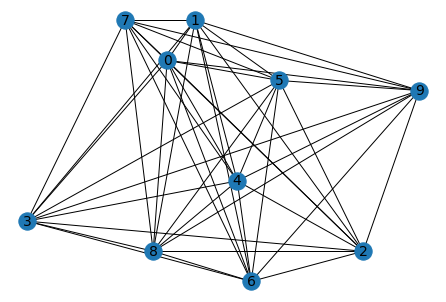

In [5]:
nodos, arcos = datos()
graficar(nodos, arcos)

Ahora que ya aprendimos a definir un grafo y graficarlo, podemos ir un poco más allá. El problema del TSP consiste en generar un ciclo a mínimo costo, que pase una vez por cada nodo. En esta primera etapa, resolveremos la relajación del problema.

In [6]:
def solve_TSP(nodos, arcos):
    """solve_TSP -- función que crea modelo en Gurobi y resuelve su relajación
    Parámetros:
        - nodos: diccionario con los id de los nodos de la forma {id nodo: (pos_x, pos_y)}
        - arcos: diccionario con los arcos de la forma {(cola,cabeza): costo} 
    Retorna arcos, modelo y variables de la relajación del TSP
    """
    model = Model("TSP")
    x = dict()
    c = dict()
    
    # definimos variables x binarias que tomen valor 1 si es que se usa ese arco, 0 e.o.c.
    for arco in arcos:
        x[arco[0], arco[1]] = model.addVar(vtype="binary", name="{},{}".format(arco[0], arco[1]))
        c[arco[0], arco[1]] = arcos[arco]
    model.update()

    # definimos restricción de que todos los nodos deben tener grado total (entrada + salida) de 2
    model.addConstrs((quicksum(x[k,i] for k in nodos if k<i) + quicksum(x[i,k] for k in nodos if k>i) == 2) for i in nodos)
    model.update()
    
    # definimos la función objetivo del problema, que es minimizar costos por arcos
    model.setObjective(quicksum(c[i,j]*x[i,j] for i in nodos for j in nodos if j>i), GRB.MINIMIZE)
    model.update()
    
    model.Params.OutputFlag = 0 # le pedimos a Gurobi que no nos printee todos sus cálculos (por defecto parámetro = 1)
    model.optimize() 
#     model.write("TSP_Relajado.lp")
    
    edges = dict()
    for (i,j) in x:
        if x[i,j].X > 0: # filtramos solamente a los arcos que toman valor mayor a 0 (que son los que uso en mi solución)
            edges[i,j] = distancia(nodos[i], nodos[j])
            
    return edges, model, x

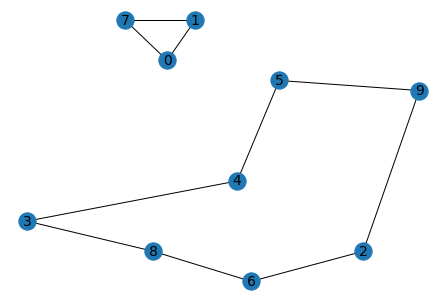

In [7]:
edges, modelo, variables = solve_TSP(nodos, arcos)
graficar(nodos, edges)

Acá nos damos cuenta que al resolver la versión relajada del problema, es posible que existan varios subciclos en nuestra solución. Para evitar esto, se recurre a lo que se conoce como 'lazy constraints', que se van agregando a medida que se van necesitando. Así, se evita aumentar la dimensionalidad del problema y se va resolviendo hasta que tengamos la solución que realmente nos sirve.

In [8]:
def subtours(arcos_usados, model, x):
    """subtours -- agrega restricción para evitar subtour específico que se le entrega
    Parámetros:
        - arcos_usados: lista de arcos de la solución actual
    Retorna True si es que se agregó un corte, Falso e.o.c.
    """
    G_aux = nx.Graph()
    G_aux.add_edges_from(arcos_usados)
    componentes = list(nx.connected_components(G_aux)) # generamos una lista de los nodos que están conectados entre sí
    print("Nodos conectados entre sí: {}".format(componentes))
    corte = False
            
    for S in componentes: #revisamos cada uno de los subciclos formados y agregamos restricción para ese subtour
        if len(S) == len(arcos_usados):
            return corte
        else: # len(S) < len(arcos_usados):
            model.addConstr(quicksum(x[i,j] for i in S for j in S if j > i) <= len(S)-1, f"subtour {S}")
            model.update()
            corte = True
    
    return corte

In [9]:
def modelo_con_cortes(model, x):
    """modelo_con_cortes -- continúa la resolución del modelo anterior, ahora llamado a las restricciones de subtours
    Parámetros:
        - model: modelo de Gurobi
        - x: diccionario con variables antes definidas en el modelo
    Retorna en pantalla un gráfico de cada una de las soluciones parciales y la final del problema.
    """
    while True: # re-optimizamos hasta que no queden subciclos
        model.optimize()
                    
        arcos_usados = []
        for (i,j) in x:
            if x[i,j].X > 0:
                arcos_usados.append((i,j))
        print("Arcos usados en la solución: {}".format(arcos_usados))
        
        if subtours(arcos_usados, model, x) == False:
            graficar(nodos, arcos_usados)
            print("Solución óptima encontrada")
            break
        else:
            graficar(nodos, arcos_usados)

Arcos usados en la solución: [(0, 1), (0, 7), (1, 7), (2, 6), (2, 9), (3, 4), (3, 8), (4, 5), (5, 9), (6, 8)]
Nodos conectados entre sí: [{0, 1, 7}, {2, 3, 4, 5, 6, 8, 9}]


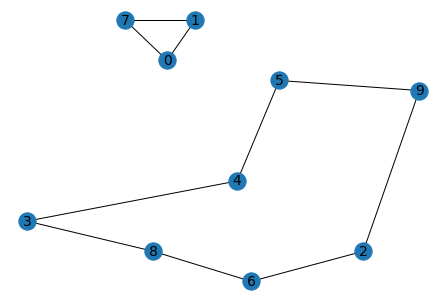

Arcos usados en la solución: [(0, 5), (0, 7), (1, 7), (1, 9), (2, 4), (2, 6), (3, 4), (3, 8), (5, 9), (6, 8)]
Nodos conectados entre sí: [{0, 1, 5, 7, 9}, {2, 3, 4, 6, 8}]


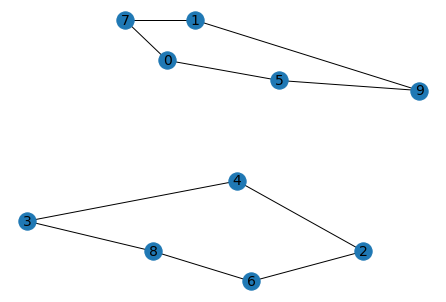

Arcos usados en la solución: [(0, 4), (0, 7), (1, 5), (1, 7), (2, 6), (2, 9), (3, 4), (3, 8), (5, 9), (6, 8)]
Nodos conectados entre sí: [{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}]


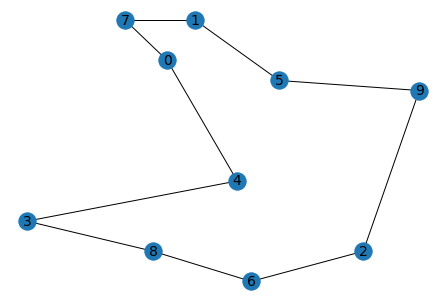

Solución óptima encontrada


In [10]:
modelo_con_cortes(modelo, variables)